In [1]:
# This notebook plots two figures with each three horizontal bargraphs. One with energy consumed and One with total delay per policy
# Per plot, the three horizontal subplots depict
# 1. Fastest Machine
# 2. TaskFlow using heterogeneity
# 3. TaskFlow using heterogeneity + DVFS
import os
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.ticker import MultipleLocator, FixedLocator, LogLocator, NullFormatter, ScalarFormatter


import numpy as np

%matplotlib inline

In [2]:
experiment_output_folder = "./ic2e-wta-output/simulation_output/"
domains = [
    ("Engineering", {"askalon",}),
    ("Industrial", {"google", "alibaba", "sigma", "shell"}),
    ("Scientific", {})  # Inferred from not matching the others.
]

workflow_delays = dict()
task_energy_used = dict()

In [3]:
if len(workflow_delays) == 0:
    for folder in next(os.walk(experiment_output_folder))[1]:
        if "parquet" not in folder: continue
        if "ali" in folder and "10k" in folder: continue
        chunks = folder.split("_")
        dvfs_enabled = chunks[-1] == "True"
        ttp = f"{chunks[-4]}_{chunks[-3]}"

        domain = "Scientific"
        if any(d in folder.lower() for d in domains[0][1]):
            domain = domains[0][0]
        elif any(d in folder.lower() for d in domains[1][1]):
            domain = domains[1][0]

        # Make sure all datastructures are initialized
        for d in [workflow_delays, task_energy_used]:
            d.setdefault(ttp, dict()) # domain dict
            d[ttp].setdefault(dvfs_enabled, dict()) # dvfs per ttp
            for val in domains:
                d[ttp][dvfs_enabled].setdefault(val[0], []) # domain per dvfs per ttp

        workflow_data = os.path.join(experiment_output_folder, folder, 'workflows.tsv')
        workflow_df = pd.read_csv(workflow_data, delimiter='\t', header=0)
        if (workflow_df['time.complete'] - workflow_df['time.earliest.complete']).min() < 0:
            print("Impossible. Verify simulation outcome!")
            exit(-1)
        workflow_delays[ttp][dvfs_enabled][domain].extend(workflow_df['time.complete'] - workflow_df['time.earliest.complete'])

        task_data = os.path.join(experiment_output_folder, folder, 'tasks.tsv')
        task_df = pd.read_csv(task_data, delimiter='\t', header=0)
        task_energy_used[ttp][dvfs_enabled][domain].extend(task_df['energy.consumed'] )

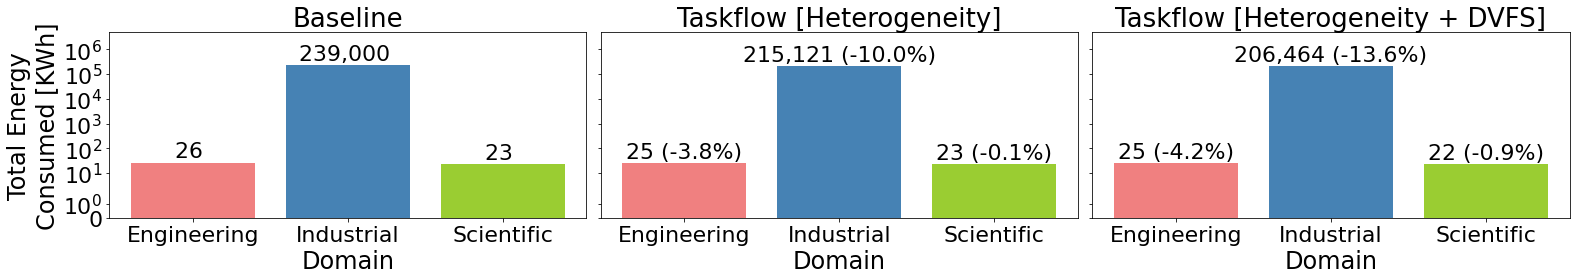

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(22, 4), sharey=True)

colors = ['lightcoral', 'steelblue', 'yellowgreen']

def autolabel(ax, rects, val):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:,.0f} {"" if val is None else f"({val:+.1f}%)"}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 1),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=22)

def create_subplot(ax, data, metric_name, title, comparison_data=None):

    labels = [d[0] for d in domains]

    x = np.arange(len(labels))  # the label locations
#     width = 0.35  # the width of the bars
#     gap = 0.0

    sums = dict()
    
    for i, label in zip(x, labels):
        sums[label] = np.sum(data[label])
        change = None if comparison_data is None else ((sums[label] - comparison_data[label]) / comparison_data[label]) * 100
        rects = ax.bar(i, sums[label] / 1000, label=label, color=colors[i])
        autolabel(ax, rects, change) 
    
    ax.set_xticks(x)
    ax.set_yscale('symlog')
    ax.set_xticklabels(labels)
    ax.tick_params(axis='both', which='major', labelsize=22)
    ax.tick_params(axis='both', which='minor', labelsize=22)
    ax.set_xlabel("Domain", fontsize=24)
    ax.set_ylabel(metric_name.format(ax.get_yaxis().get_major_formatter().get_offset()), fontsize=24)
    ax.set_title(title, fontsize=26)
    
    return sums
    
# One row with the Energy plots
sums = create_subplot(ax1, task_energy_used['fastest_machine'][False], "Total Energy\nConsumed [KWh]", "Baseline")
create_subplot(ax2, task_energy_used['look_ahead'][False], "", "Taskflow [Heterogeneity]", sums)
create_subplot(ax3, task_energy_used['look_ahead'][True], "", "Taskflow [Heterogeneity + DVFS]", sums)

xmin, xmax, ymin, ymax = plt.axis()
plt.ylim(0, ymax*10)

fig.tight_layout()
date_time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
fig.savefig(f"energy_consumption_baseline_taskflow_{date_time}.pdf", bbox_inches = "tight")

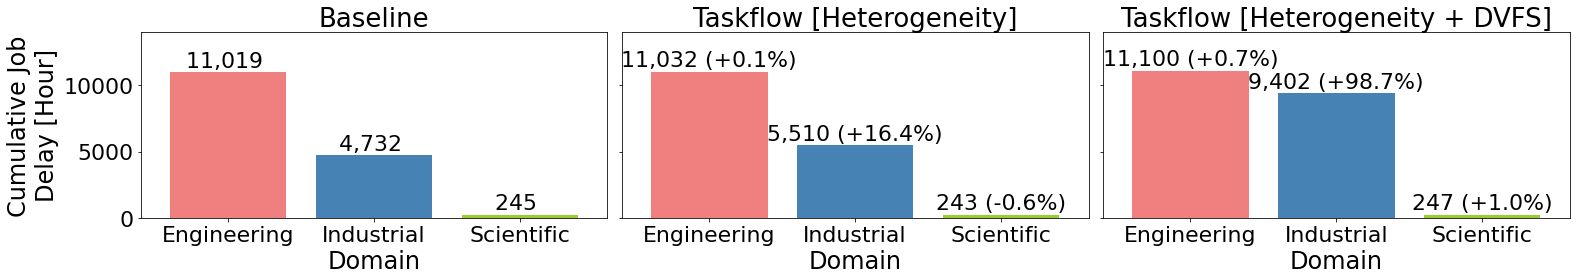

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(22, 4), sharey=True)

colors = ['lightcoral', 'steelblue', 'yellowgreen']

def autolabel(ax, rects, val):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:,.0f} {"" if val is None else f"({val:+.1f}%)"}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 1),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=22)

def create_subplot(ax, data, metric_name, title, comparison_data=None):

    labels = [d[0] for d in domains]

    x = np.arange(len(labels))  # the label locations

    sums = dict()
    
    for i, label in zip(x, labels):
        sums[label] = np.sum(data[label])
        change = None if comparison_data is None else ((sums[label] - comparison_data[label]) / comparison_data[label]) * 100
        rects = ax.bar(i, sums[label] / (1000 * 60 * 60), label=label, color=colors[i])
        autolabel(ax, rects, change) 
    
    ax.yaxis.get_offset_text().set_visible(False)
    ax.get_yaxis().set_major_formatter(ScalarFormatter(useMathText=True))
    fig.tight_layout() # Need to so we can get the offset of the major formatter...
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_xlim(x.min() - .6, x.max() + .6)
    ax.tick_params(axis='both', which='major', labelsize=22)
    ax.tick_params(axis='both', which='minor', labelsize=22)
    ax.set_xlabel("Domain", fontsize=24)
    ax.set_ylabel(metric_name, fontsize=24)
    ax.set_title(title, fontsize=26)
    
    return sums
    
# One row with the Energy plots
sums = create_subplot(ax1, workflow_delays['fastest_machine'][False], "Cumulative Job\nDelay [Hour]", "Baseline")
create_subplot(ax2, workflow_delays['look_ahead'][False], "", "Taskflow [Heterogeneity]", sums)
create_subplot(ax3, workflow_delays['look_ahead'][True], "", "Taskflow [Heterogeneity + DVFS]", sums)

xmin, xmax, ymin, ymax = plt.axis()
plt.ylim(0, ymax*1.2)

fig.tight_layout()
date_time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
fig.savefig(f"cummulative_workflow_delay_baseline_taskflow_{date_time}.pdf", bbox_inches = "tight")

In [6]:
for domain in task_energy_used['fastest_machine'][False]:
    print(domain, len(task_energy_used['fastest_machine'][False][domain]))

Engineering 238181
Industrial 31659553
Scientific 58569


In [ ]:
workflow_data = os.path.join(experiment_output_folder, 'alibaba_first_100k_wfids_parquet_tu_0.4_tsp_fcfs_tpp_look_ahead_dvfs_True', 'workflows.tsv')
workflow_df = pd.read_csv(workflow_data, delimiter='\t', header=0)

def normalize(df):
    df = df.value_counts(sort=False, normalize=True).rename_axis('target').reset_index(name='pdf')
    df["cdf"] = df["pdf"].cumsum()
    return df

all_values_df = pd.DataFrame({"target": (workflow_df['time.complete'] - workflow_df['time.earliest.complete']) / (1000 * 60)})
# Add a row at the start so that the CDF starts at 0 and ends at 1 (in case we only have one datapoint in the DF)
plot_df = normalize(all_values_df)
percentages = [0.01, 0.25, 0.50, 0.75, 0.90, 0.99, 1]
values = []

t = '''\\begin{{table}}[]
\\caption{{Workflow delay [min] for the Alibaba workload.}}
\\label{{slack:tbl:alibaba}}
\\begin{{tabular}}{{@{{}}lrrrrrrr@{{}}}}
\\toprule
    & 1\\% & 25\\% & 50\\% & 75\\% & 90\\% & 99\\% & 100\\% \\\\ \\midrule
RAM & {0}    & {1}     & {2}     & {3}     & {4}     & {5}    & {6} \\\\ \\bottomrule
\\end{{tabular}}
\\end{{table}}'''

for p in percentages:
    values.append(plot_df[plot_df['cdf'].ge(p) | np.isclose(plot_df['cdf'], p, rtol=1e-8, atol=1e-12)].iloc[0]['target'])

print(t.format(*["{:.2f}".format(v) for v in values]))